In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from keras.datasets import imdb
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import gensim
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess
from gensim.models.keyedvectors import KeyedVectors
from keras.layers import Dense, Input, GlobalMaxPooling1D
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.models import Model
from keras.layers import Input, Dense, Embedding, Conv2D, MaxPooling2D, Dropout,concatenate
from keras.layers.core import Reshape, Flatten
from keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from keras.models import Model
from keras import regularizers
from keras.layers import Embedding
import pickle as pkl

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd /content/drive/MyDrive/301_project

/content/drive/.shortcut-targets-by-id/1MYdHZqeVKSuQzIzZWrfBqMgi2EgY91a0/301_project


In [ ]:
import pandas as pd
import numpy as np

df = pd.read_csv("imdb.csv", usecols=["review", "sentiment"], encoding='latin-1')
## 1 - positive, 0 - negative
df.sentiment = (df.sentiment == "positive").astype("int")
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


## split

In [ ]:
val_size = int(df.shape[0] * 0.15)
test_size = int(df.shape[0] * 0.15)


def train_val_test_split(df=None, train_percent=0.7, test_percent=0.15, val_percent=0.15):
  df = df.sample(frac=1)
  train_df = df[: int(len(df)*train_percent)]
  test_df = df[int(len(df)*train_percent)+1 : int(len(df)*(train_percent+test_percent))]
  val_df = df[int(len(df)*(train_percent + test_percent))+1 : ]
  return train_df, test_df, val_df

train_df, test_df, val_df = train_val_test_split(df, 0.7, 0.15, 0.15)
train_labels, train_texts = train_df.values[:,1], train_df.values[:,0]
val_labels, val_texts = val_df.values[:,1], val_df.values[:,0]
test_labels, test_texts = test_df.values[:,1], test_df.values[:,0]
print(len(train_df), len(test_df), len(val_df))
print(len(train_texts), len(train_labels), len(val_df))

35000 7499 7499
35000 35000 7499


In [ ]:
train_texts[0]

"Mary Haines (Meg Ryan) a rich woman discovers her husband is cheating on her with a younger woman (Eva Mendes). She doesn't know what to do and friends Sylvia Fowler (Annette Bening), Edie Cohen (Debra Messing) and Alex Fisher (Jad Pinkett Smith) try to help.<br /><br />OK--there was no reason to redo the 1939 movie. That's a true classic and doesn't need to be updated and redone. Naturally it WAS done. This has gotten some of the worst reviews I've ever seen for a motion picture. I love the original and have seen it MANY times--I was constantly comparing it to that. Now this isn't a classic but it's not that bad.<br /><br />**MINOR SPOILERS!!!** First the bad--the story is old and was (badly) updated. Really--a man cheating on his wife is hardly shocking today. Meg Ryan (a wonderful actress) is pretty terrible here. Her face seems unable to change expression! I couldn't believe how bad some of her scenes came over. Eva Mendes is bad too--but it's not entirely her fault. Her role is b

In [ ]:
train_labels

array([1, 0, 0, ..., 1, 1, 0], dtype=object)

## Tokenize text of the training data with keras text preprocessing functions

In [ ]:
#english

from spacy.tokenizer import Tokenizer
from spacy.lang.en import English

def process_tokens(text):
    """
    function to process tokens, replace any unwanted chars
    """
    preprocessed_text = text.lower().replace(",", "").replace(".", "").replace(":", "").replace(")", "").replace("-", "").replace("(", "")
    preprocessed_text = ''.join([i for i in preprocessed_text if not preprocessed_text.isdigit()])
    return preprocessed_text

def preprocessing(data):
    """
    preprocessing data to list of tokens
    """
    nlp = English()
    tokenizer = Tokenizer(nlp.vocab)
    preprocessed_data = []
    for sentence in data:
        sentence = process_tokens(sentence)
        tokens = tokenizer(sentence)
        tlist = []
        for token in tokens:
            tlist.append(str(token))
        preprocessed_data.append(tlist)
    return preprocessed_data

train_data = preprocessing(train_texts)
val_data = preprocessing(val_texts)
test_data = preprocessing(test_texts)




In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [ ]:
NUM_WORDS=20000
tokenizer = Tokenizer(num_words=NUM_WORDS,filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n\'',
                      lower=True)

In [ ]:
tokenizer.fit_on_texts(train_data)
sequences_train = tokenizer.texts_to_sequences(train_data)
sequences_valid=tokenizer.texts_to_sequences(val_data)
sequences_test=tokenizer.texts_to_sequences(test_data)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 208949 unique tokens.


In [ ]:
len(word_index)

208949

In [ ]:
#decode y

y_train = np.array(train_labels)
y_val = np.array(val_labels)
y_test = np.array(test_labels)

y_train = y_train.astype('int')
y_val = y_val.astype('int')
y_test = y_test.astype('int')

from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 2)
y_test = to_categorical(y_test, 2)
y_val = to_categorical(y_val, 2)

In [ ]:
print(f'X_train.shape: {len(sequences_train)}, y_train.shape: {y_train.shape}')

X_train.shape: 35000, y_train.shape: (35000, 2)


### pad sequence

In [ ]:
X_train = pad_sequences(sequences_train)
X_val = pad_sequences(sequences_valid,maxlen=X_train.shape[1])
X_test=pad_sequences(sequences_test,maxlen=X_train.shape[1])

In [ ]:

print('Shape of X train and X validation tensor:', X_train.shape,X_val.shape)
print('Shape of label train and validation tensor:', y_train.shape,y_val.shape)

Shape of X train and X validation tensor: (35000, 2241) (7499, 2241)
Shape of label train and validation tensor: (35000, 2) (7499, 2)


## use word2vec as embedding layer

In [ ]:
import gensim
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess

from gensim.models.keyedvectors import KeyedVectors


EMBEDDING_DIM=300
vocabulary_size=min(len(word_index)+1,NUM_WORDS)


In [ ]:


vocabulary_size

20000

In [ ]:
#don't run
word_vectors = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)

embedding_matrix = np.zeros((vocabulary_size, EMBEDDING_DIM))
for word, i in word_index.items():
    if i>=NUM_WORDS:
        continue
    try:
        embedding_vector = word_vectors[word]
        embedding_matrix[i] = embedding_vector
    except KeyError:
        print(f'word {word} not in w2v')
        embedding_matrix[i]=np.random.normal(0,np.sqrt(0.25),EMBEDDING_DIM)

del(word_vectors)

word and not in w2v
word a not in w2v
word of not in w2v
word to not in w2v
word /><br not in w2v
word   not in w2v
word />the not in w2v
word <br not in w2v
word i'm not in w2v
word />i not in w2v
word i've not in w2v
word "the not in w2v
word />this not in w2v
word 10 not in w2v
word â not in w2v
word i'd not in w2v
word />in not in w2v
word />it not in w2v
word film's not in w2v
word />if not in w2v
word it<br not in w2v
word />but not in w2v
word />there not in w2v
word i'll not in w2v
word movie<br not in w2v
word film<br not in w2v
word />and not in w2v
word ! not in w2v
word />a not in w2v
word />as not in w2v
word />it's not in w2v
word 20 not in w2v
word 'the not in w2v
word />so not in w2v
word />what not in w2v
word it! not in w2v
word "i not in w2v
word   not in w2v
word humour not in w2v
word 80's not in w2v
word 15 not in w2v
word 30 not in w2v
word />all not in w2v
word />my not in w2v
word movie's not in w2v
word />one not in w2v
word " not in w2v
word ? not in w2v
wo

In [ ]:
#dump to pkl
with open('em_w2v_train.pkl', 'wb') as handle:
    pkl.dump(embedding_matrix, handle)

In [ ]:
# load if saevd
with open('em_w2v_train.pkl', 'rb') as handle:
    embedding_matrix=pkl.load(handle)

In [ ]:
from keras.layers import Embedding
embedding_layer = Embedding(vocabulary_size,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            trainable=False)  #-------unsure

In [ ]:
embedding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.08007812,  0.10498047,  0.04980469, ...,  0.00366211,
         0.04760742, -0.06884766],
       [-0.91204109,  0.88575532,  0.0025902 , ..., -0.50070606,
        -0.4411896 , -0.5499527 ],
       ...,
       [ 0.08837891,  0.10644531,  0.09912109, ..., -0.15820312,
        -0.04760742, -0.07226562],
       [ 0.01281738,  0.0078125 , -0.02758789, ..., -0.11328125,
         0.05151367,  0.15820312],
       [ 0.01275635, -0.12988281, -0.10058594, ..., -0.01928711,
        -0.18261719,  0.12695312]])

In [ ]:
embedding_matrix.shape

(20000, 300)

# normal embedding

In [ ]:
from keras.layers import Embedding
EMBEDDING_DIM=100
vocabulary_size=min(len(word_index)+1,NUM_WORDS)

embedding_layer = Embedding(vocabulary_size,
                            EMBEDDING_DIM)

# model

In [ ]:
from keras.layers import Dense, Input, GlobalMaxPooling1D
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.models import Model
from keras.layers import Input, Dense, Embedding, Conv2D, MaxPooling2D, Dropout,concatenate
from keras.layers.core import Reshape, Flatten
from keras.callbacks import EarlyStopping
from keras.models import Model
from keras import regularizers

In [ ]:
def Conv1():
  sequence_length = X_train.shape[1]
  filter_sizes = [3,4,5]
  num_filters = 100
  drop = 0.5
  num_classes=2

  inputs = Input(shape=(sequence_length,))
  embedding = embedding_layer(inputs)
  #reshape = Reshape((sequence_length,EMBEDDING_DIM,1))(embedding)

  conv_0 = Conv2D(filter_sizes[0], EMBEDDING_DIM,num_filters,activation='relu',kernel_regularizer=regularizers.l2(0.01))(embedding)
  conv_1 = Conv2D(num_filters, (filter_sizes[1], EMBEDDING_DIM),activation='relu',kernel_regularizer=regularizers.l2(0.01))(embedding)
  conv_2 = Conv2D(num_filters, (filter_sizes[2], EMBEDDING_DIM),activation='relu',kernel_regularizer=regularizers.l2(0.01))(embedding)

  maxpool_0 = MaxPooling2D((sequence_length - filter_sizes[0] + 1, 1), strides=(1,1))(conv_0)
  maxpool_1 = MaxPooling2D((sequence_length - filter_sizes[1] + 1, 1), strides=(1,1))(conv_1)
  maxpool_2 = MaxPooling2D((sequence_length - filter_sizes[2] + 1, 1), strides=(1,1))(conv_2)

  merged_tensor = concatenate([maxpool_0, maxpool_1, maxpool_2], axis=1)
  flatten = Flatten()(merged_tensor)
  reshape = Reshape((3*num_filters,))(flatten)
  dropout = Dropout(drop)(flatten)
  output = Dense(units=num_classes, activation='softmax',kernel_regularizer=regularizers.l2(0.01))(dropout)

  # this creates a model that includes
  model = Model(inputs, output)

  return model

model=Conv1()

ValueError: ignored

In [ ]:
# def Conv1():
#   sequence_length = X_train.shape[1]
#   filter_sizes = [3,4,5]
#   num_filters = 100
#   drop = 0.5
#   num_classes=2

#   inputs = Input(shape=(sequence_length,))
#   embedding = embedding_layer(inputs)
#   reshape = Reshape((sequence_length,EMBEDDING_DIM,1))(embedding)

#   conv_0 = Conv2D(num_filters, (filter_sizes[0], EMBEDDING_DIM),activation='relu',kernel_regularizer=regularizers.l2(0.01))(reshape)
#   conv_1 = Conv2D(num_filters, (filter_sizes[1], EMBEDDING_DIM),activation='relu',kernel_regularizer=regularizers.l2(0.01))(reshape)
#   conv_2 = Conv2D(num_filters, (filter_sizes[2], EMBEDDING_DIM),activation='relu',kernel_regularizer=regularizers.l2(0.01))(reshape)

#   maxpool_0 = MaxPooling2D((sequence_length - filter_sizes[0] + 1, 1), strides=(1,1))(conv_0)
#   maxpool_1 = MaxPooling2D((sequence_length - filter_sizes[1] + 1, 1), strides=(1,1))(conv_1)
#   maxpool_2 = MaxPooling2D((sequence_length - filter_sizes[2] + 1, 1), strides=(1,1))(conv_2)

#   merged_tensor = concatenate([maxpool_0, maxpool_1, maxpool_2], axis=1)
#   flatten = Flatten()(merged_tensor)
#   reshape = Reshape((3*num_filters,))(flatten)
#   dropout = Dropout(drop)(flatten)
#   output = Dense(units=num_classes, activation='softmax',kernel_regularizer=regularizers.l2(0.01))(dropout)

#   # this creates a model that includes
#   model = Model(inputs, output)

#   return model

# model=Conv1()

In [ ]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 2258)]       0           []                               
                                                                                                  
 embedding_2 (Embedding)        (None, 2258, 100)    2000000     ['input_3[0][0]']                
                                                                                                  
 reshape_4 (Reshape)            (None, 2258, 100, 1  0           ['embedding_2[0][0]']            
                                )                                                                 
                                                                                                  
 conv2d_6 (Conv2D)              (None, 2256, 1, 100  30100       ['reshape_4[0][0]']        

# run model

In [ ]:
from datetime import datetime

In [ ]:
# Custom Class to print specified parameters during training
class PrintingCallback(tf.keras.callbacks.Callback):
    
    def on_epoch_end(self, epoch, logs=None):
        # print(logs.keys())
        print(
            "The average loss for epoch {} is {:7.2f} "
            "and accuracy is {:7.2f}.".format(
                epoch, logs["val_loss"], logs["val_accuracy"]
            ))
        lr = tf.keras.backend.get_value(self.model.optimizer.learning_rate)
        print("LR is:", lr)
    

# defining a function to checkpoint the model 

checkpoint_filepath = './tmp/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose = True)




optimizer = Adam()
model.compile(loss='categorical_crossentropy', optimizer=optimizer,
              metrics=['accuracy'])
print(model.summary())
history = model.fit(X_train, y_train,
          batch_size=256,
          validation_data=(X_val, y_val),
          epochs=2)
print(history.history.keys())

In [ ]:
adam = Adam(lr=1e-3)

model.compile(loss='categorical_crossentropy',
              optimizer=adam,
              metrics=['accuracy'])
#callbacks = [EarlyStopping(monitor='val_loss')]

start = datetime.now()

history = model.fit(X_train, y_train, batch_size=256, epochs=10, verbose=1, validation_data=(X_val, y_val),
         callbacks=[PrintingCallback(), model_checkpoint_callback])  # starts training

end = datetime.now()

print('time: ',end-start)

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


137/137 [==============================] - ETA: 0s - loss: 0.6342 - accuracy: 0.7147The average loss for epoch 0 is    0.53 and accuracy is    0.79.
LR is: 0.001

Epoch 1: val_accuracy improved from -inf to 0.79157, saving model to ./tmp/checkpoint
137/137 [==============================] - 39s 273ms/step - loss: 0.6342 - accuracy: 0.7147 - val_loss: 0.5307 - val_accuracy: 0.7916
Epoch 2/10
137/137 [==============================] - ETA: 0s - loss: 0.4904 - accuracy: 0.8276The average loss for epoch 1 is    0.47 and accuracy is    0.83.
LR is: 0.001

Epoch 2: val_accuracy improved from 0.79157 to 0.83091, saving model to ./tmp/checkpoint
137/137 [==============================] - 40s 292ms/step - loss: 0.4904 - accuracy: 0.8276 - val_loss: 0.4741 - val_accuracy: 0.8309
Epoch 3/10
137/137 [==============================] - ETA: 0s - loss: 0.4362 - accuracy: 0.8676The average loss for epoch 2 is    0.46 and accuracy is    0.85.
LR is: 0.001

Epoch 3: val_accuracy improved from 0.83091 to

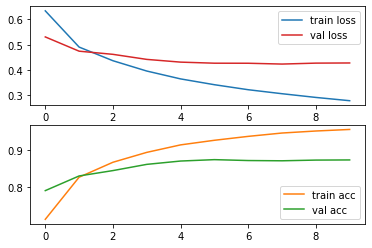

In [ ]:
import matplotlib.pyplot as plt
num_epoch=10
f, (ax1, ax2) = plt.subplots(2, 1)
ax1.plot(range(num_epoch), history.history['loss'], 'tab:blue', label="train loss")
ax1.plot(range(num_epoch), history.history['val_loss'], 'tab:red', label="val loss")

ax2.plot(range(num_epoch), history.history['accuracy'], 'tab:orange', label="train acc")
ax2.plot(range(num_epoch), history.history['val_accuracy'], 'tab:green', label="val acc")

ax1.legend()
ax2.legend()

In [ ]:
#load from chkpt and continueto train
model.load_weights(checkpoint_filepath)

adam = Adam(lr=1e-3)

model.compile(loss='binary_crossentropy',
              optimizer=adam,
              metrics=['accuracy'])

start = datetime.now()

history2 = model.fit(X_train, y_train, batch_size=256, epochs=10, verbose=1, validation_data=(X_val, y_val),
         callbacks=[PrintingCallback(), model_checkpoint_callback])  # starts training

end = datetime.now()

print('time: ',end-start)

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


137/137 [==============================] - ETA: 0s - loss: 0.4093 - accuracy: 0.9237The average loss for epoch 0 is    0.48 and accuracy is    0.87.
LR is: 0.001

Epoch 1: val_accuracy did not improve from 0.87465
137/137 [==============================] - 41s 277ms/step - loss: 0.4093 - accuracy: 0.9237 - val_loss: 0.4808 - val_accuracy: 0.8672
Epoch 2/10
137/137 [==============================] - ETA: 0s - loss: 0.3872 - accuracy: 0.9265The average loss for epoch 1 is    0.47 and accuracy is    0.87.
LR is: 0.001

Epoch 2: val_accuracy did not improve from 0.87465
137/137 [==============================] - 38s 281ms/step - loss: 0.3872 - accuracy: 0.9265 - val_loss: 0.4696 - val_accuracy: 0.8670
Epoch 3/10
137/137 [==============================] - ETA: 0s - loss: 0.3722 - accuracy: 0.9313The average loss for epoch 2 is    0.46 and accuracy is    0.87.
LR is: 0.001

Epoch 3: val_accuracy did not improve from 0.87465
137/137 [==============================] - 39s 286ms/step - loss: 0.

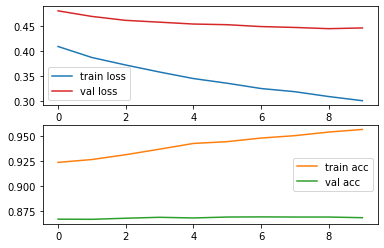

In [ ]:
import matplotlib.pyplot as plt
num_epoch=10
f, (ax1, ax2) = plt.subplots(2, 1)
ax1.plot(range(num_epoch), history2.history['loss'], 'tab:blue', label="train loss")
ax1.plot(range(num_epoch), history2.history['val_loss'], 'tab:red', label="val loss")

ax2.plot(range(num_epoch), history2.history['accuracy'], 'tab:orange', label="train acc")
ax2.plot(range(num_epoch), history2.history['val_accuracy'], 'tab:green', label="val acc")

ax1.legend()
ax2.legend()

In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

# test

In [ ]:
start = datetime.now()
score, acc = model.evaluate(X_test, y_test, verbose=0)
end = datetime.now()
print('Test loss:', score)
print('Test accuracy:', acc)
print('time: ',end-start)

Test loss: 0.43917739391326904
Test accuracy: 0.8723829984664917
time:  0:00:03.852297


In [ ]:
model.load_weights(checkpoint_filepath)

start = datetime.now()
score, acc = model.evaluate(X_test, y_test, verbose=0)
end = datetime.now()
print('Test loss:', score)
print('Test accuracy:', acc)
print('time: ',end-start)

Test loss: 0.5044785737991333
Test accuracy: 0.874383270740509
time:  0:00:05.180454
